# Home Credit Default Risk - Preprocessing & Feature Engineering


In [1]:
import pandas as pd
import numpy as np
import sys
import gc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
import plotly.offline as py
from plotly.offline import init_notebook_mode, iplot
import plotly.io as pio
from sklearn.model_selection import KFold
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings('ignore')
init_notebook_mode(connected=True)
pio.renderers.default = "notebook_connected"
sns.set_style('whitegrid')

## 1. Load Data

In [2]:
BASE_PATH = '/Users/tushsriv/Desktop/iisc/DSIP_Project/dataset'

application_train = pd.read_csv(f'{BASE_PATH}/application_train.csv')
application_test = pd.read_csv(f'{BASE_PATH}/application_test.csv')
bureau = pd.read_csv(f'{BASE_PATH}/bureau.csv')
bureau_balance = pd.read_csv(f'{BASE_PATH}/bureau_balance.csv')
credit_card_balance = pd.read_csv(f'{BASE_PATH}/credit_card_balance.csv')
installments_payments = pd.read_csv(f'{BASE_PATH}/installments_payments.csv')
POS_CASH_balance = pd.read_csv(f'{BASE_PATH}/POS_CASH_balance.csv')
previous_application = pd.read_csv(f'{BASE_PATH}/previous_application.csv')

print(f'Training data: {application_train.shape}')
print(f'Test data: {application_test.shape}')
print(f'Bureau: {bureau.shape}')
print(f'Bureau balance: {bureau_balance.shape}')
print(f'Credit card: {credit_card_balance.shape}')
print(f'Installments: {installments_payments.shape}')
print(f'POS CASH: {POS_CASH_balance.shape}')
print(f'Previous applications: {previous_application.shape}')

Training data: (307511, 122)
Test data: (48744, 121)
Bureau: (1716428, 17)
Bureau balance: (27299925, 3)
Credit card: (3840312, 23)
Installments: (13605401, 8)
POS CASH: (10001358, 8)
Previous applications: (1670214, 37)


## 2. Helper Functions

In [3]:
# def return_size(df):
#     """Return size of dataframe in gigabytes"""
#     return round(sys.getsizeof(df) / 1e9, 2)

def convert_types(df):
    # original_memory = df.memory_usage().sum()
    
    for c in df:
        if 'SK_ID' in c:
            df[c] = df[c].fillna(0).astype(np.int32)
        elif (df[c].dtype == 'object') and (df[c].nunique() < df.shape[0]):
            df[c] = df[c].astype('category')
        elif list(df[c].unique()) == [1, 0]:
            df[c] = df[c].astype(bool)
        elif df[c].dtype == float:
            df[c] = df[c].astype(np.float32)
        elif df[c].dtype == int:
            df[c] = df[c].astype(np.int32)
    
    return df

def missing_values_table(df):
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'})
    mis_val_table_ren = mis_val_table_ren[
        mis_val_table_ren.iloc[:, 1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
    
    print(f"Dataset has {df.shape[1]} columns.")
    print(f"{mis_val_table_ren.shape[0]} columns have missing values.\n")
    
    return mis_val_table_ren

def kde_target(var_name, df):
    """Plot distribution of variable by target value"""
    corr = df['TARGET'].corr(df[var_name])
    avg_repaid = df.loc[df['TARGET'] == 0, var_name].median()
    avg_not_repaid = df.loc[df['TARGET'] == 1, var_name].median()
    
    plt.figure(figsize=(12, 6))
    sns.kdeplot(df.loc[df['TARGET'] == 0, var_name], label='TARGET == 0', fill=True)
    sns.kdeplot(df.loc[df['TARGET'] == 1, var_name], label='TARGET == 1', fill=True)
    
    plt.xlabel(var_name)
    plt.ylabel('Density')
    plt.title(f'{var_name} Distribution by Target')
    plt.legend()
    
    print(f'Correlation with TARGET: {corr:.4f}')
    print(f'Median (not repaid): {avg_not_repaid:.4f}')
    print(f'Median (repaid): {avg_repaid:.4f}')


In [4]:
# def agg_numeric(df, group_var, df_name):
#     """Aggregate numeric features by grouping variable"""
#     for col in df:
#         if col != group_var and 'SK_ID' in col:
#             df = df.drop(columns=col)
    
#     group_ids = df[group_var]
#     numeric_df = df.select_dtypes('number')
#     numeric_df[group_var] = group_ids
    
#     agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()
    
#     columns = [group_var]
#     for var in agg.columns.levels[0]:
#         if var != group_var:
#             for stat in agg.columns.levels[1][:-1]:
#                 columns.append(f'{df_name}_{var}_{stat}')
    
#     agg.columns = columns
#     return agg

# def agg_categorical_target_encoded(df, group_var, df_name):
#     """Aggregate categorical features using frequency encoding"""
#     categorical_cols = df.select_dtypes(include=['category', 'object']).columns.tolist()
    
#     if len(categorical_cols) == 0:
#         return pd.DataFrame()
    
#     encoded_df = df.copy()
    
#     for col in categorical_cols:
#         if col != group_var:
#             freq_map = df[col].value_counts(normalize=True).to_dict()
#             encoded_df[f'{col}_freq'] = df[col].map(freq_map).fillna(0)
#             encoded_df = encoded_df.drop(columns=[col])
    
#     numeric_cols = encoded_df.select_dtypes(include=[np.number]).columns.tolist()
#     if group_var not in numeric_cols:
#         numeric_cols.append(group_var)
    
#     encoded_df = encoded_df[numeric_cols]
#     categorical = encoded_df.groupby(group_var).agg(['sum', 'count', 'mean'])
    
#     column_names = []
#     for var in categorical.columns.levels[0]:
#         for stat in ['sum', 'count', 'mean']:
#             column_names.append(f'{df_name}_{var}_{stat}')
    
#     categorical.columns = column_names
#     _, idx = np.unique(categorical, axis=1, return_index=True)
#     categorical = categorical.iloc[:, idx]
    
#     return categorical

# print('✓ Aggregation functions defined')

## Application Training & Testing Data

In [5]:
# Create copies for processing
app_train = application_train.copy()
app_test = application_test.copy()

print('APPLICATION DATA OVERVIEW')
print(f'Training shape: {app_train.shape}')
print(f'Test shape: {app_test.shape}')
print(f'\nTarget distribution:')
print(app_train['TARGET'].value_counts())
print(f'\nDefault rate: {100 * app_train["TARGET"].mean():.2f}%')

APPLICATION DATA OVERVIEW
Training shape: (307511, 122)
Test shape: (48744, 121)

Target distribution:
TARGET
0    282686
1     24825
Name: count, dtype: int64

Default rate: 8.07%


In [6]:
print(app_train.dtypes.value_counts())

float64    65
int64      41
object     16
Name: count, dtype: int64


In [7]:
# Missing values analysis
missing_train = missing_values_table(app_train)
missing_train.head(20)

Dataset has 122 columns.
67 columns have missing values.



,Missing Values,% of Total Values
COMMONAREA_MEDI,214865,69.9
COMMONAREA_AVG,214865,69.9
COMMONAREA_MODE,214865,69.9
NONLIVINGAPARTMENTS_MEDI,213514,69.4
NONLIVINGAPARTMENTS_MODE,213514,69.4
NONLIVINGAPARTMENTS_AVG,213514,69.4
FONDKAPREMONT_MODE,210295,68.4
LIVINGAPARTMENTS_MODE,210199,68.4
LIVINGAPARTMENTS_MEDI,210199,68.4
LIVINGAPARTMENTS_AVG,210199,68.4


In [8]:
app_train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

NAME_CONTRACT_TYPE             2
CODE_GENDER                    3
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
NAME_TYPE_SUITE                7
NAME_INCOME_TYPE               8
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
OCCUPATION_TYPE               18
WEEKDAY_APPR_PROCESS_START     7
ORGANIZATION_TYPE             58
FONDKAPREMONT_MODE             4
HOUSETYPE_MODE                 3
WALLSMATERIAL_MODE             7
EMERGENCYSTATE_MODE            2
dtype: int64

### Data Encoding

In [9]:
# Create a label encoder object
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in app_train:
    if app_train[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(app_train[col].unique())) <= 2:
            # Train on the training data
            le.fit(app_train[col])
            # Transform both training and testing data
            app_train[col] = le.transform(app_train[col])
            app_test[col] = le.transform(app_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [10]:
# one-hot encoding of categorical variables
app_train = pd.get_dummies(app_train)
app_test = pd.get_dummies(app_test)

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 243)
Testing Features shape:  (48744, 239)


In [11]:
train_labels = app_train['TARGET']

# Align the training and testing data, keep only columns present in both dataframes
app_train, app_test = app_train.align(app_test, join = 'inner', axis = 1)

# Add the target back in
app_train['TARGET'] = train_labels

print('Training Features shape: ', app_train.shape)
print('Testing Features shape: ', app_test.shape)

Training Features shape:  (307511, 240)
Testing Features shape:  (48744, 239)


### Anomaly Detection

In [12]:
app_train[["DAYS_EMPLOYED","DAYS_BIRTH"]]

,DAYS_EMPLOYED,DAYS_BIRTH
0,-637,-9461
1,-1188,-16765
2,-225,-19046
3,-3039,-19005
4,-3038,-19932
...,...,...
307506,-236,-9327
307507,365243,-20775
307508,-7921,-14966
307509,-4786,-11961


In [13]:
(app_train['DAYS_BIRTH'] / -365).describe()

count    307511.000000
mean         43.936973
std          11.956133
min          20.517808
25%          34.008219
50%          43.150685
75%          53.923288
max          69.120548
Name: DAYS_BIRTH, dtype: float64

Text(0.5, 0, 'Days Employment')

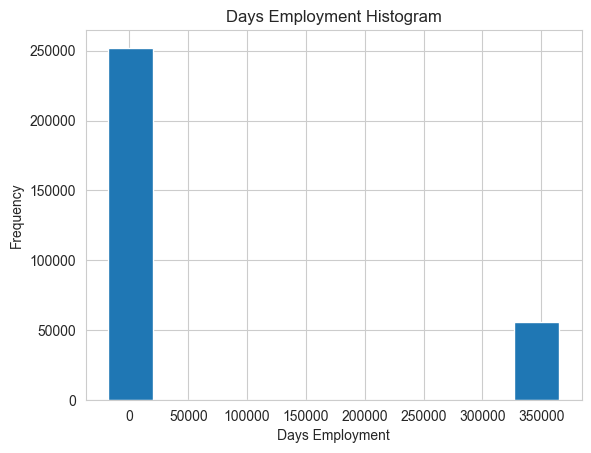

In [14]:
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram');
plt.xlabel('Days Employment')

In [15]:
# # remove app_train['DAYS_EMPLOYED'] == 365243
# app_train = app_train[app_train['DAYS_EMPLOYED'] != 365243]
# app_test = app_test[app_test['DAYS_EMPLOYED'] != 365243]

In [16]:
anom = app_train[app_train['DAYS_EMPLOYED'] == 365243]
non_anom = app_train[app_train['DAYS_EMPLOYED'] != 365243]
print('The non-anomalies default on %0.2f%% of loans' % (100 * non_anom['TARGET'].mean()))
print('The anomalies default on %0.2f%% of loans' % (100 * anom['TARGET'].mean()))
print('There are %d anomalous days of employment' % len(anom))

The non-anomalies default on 8.66% of loans
The anomalies default on 5.40% of loans
There are 55374 anomalous days of employment


Since its a huge chunk of data with abnormal days employement, we will not remove but replace with np.nan for now

Text(0.5, 0, 'Days Employment')

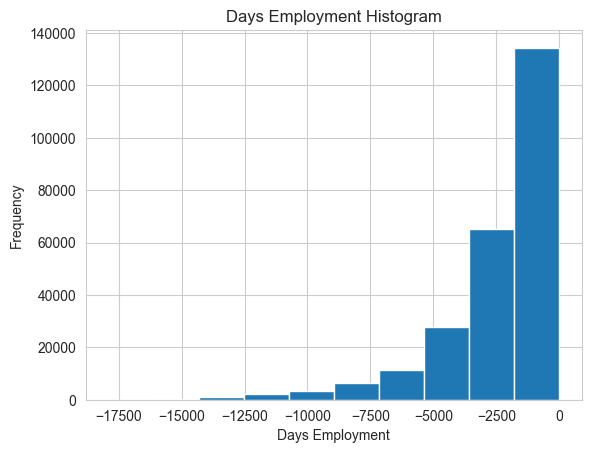

In [17]:
# Create an anomalous flag column
app_train['DAYS_EMPLOYED_ANOM'] = app_train["DAYS_EMPLOYED"] == 365243
app_train['DAYS_EMPLOYED'].replace({365243: np.nan}, inplace = True)
app_train['DAYS_EMPLOYED'].plot.hist(title = 'Days Employment Histogram')
plt.xlabel('Days Employment')

In [18]:
app_test['DAYS_EMPLOYED_ANOM'] = app_test["DAYS_EMPLOYED"] == 365243
app_test["DAYS_EMPLOYED"].replace({365243: np.nan}, inplace = True)

print('There are %d anomalies in the test data out of %d entries' % (app_test["DAYS_EMPLOYED_ANOM"].sum(), len(app_test)))

There are 9274 anomalies in the test data out of 48744 entries


### Feature Engineering

In [19]:
# Find correlations with the target and sort
correlations = app_train.corr()['TARGET'].sort_values()

# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))

Most Positive Correlations:
 OCCUPATION_TYPE_Laborers                             0.043019
FLAG_DOCUMENT_3                                      0.044346
REG_CITY_NOT_LIVE_CITY                               0.044395
FLAG_EMP_PHONE                                       0.045982
NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                                 0.058899
REGION_RATING_CLIENT_W_CITY                          0.060893
DAYS_EMPLOYED                                        0.074958
DAYS_BIRTH                                           0.078239
TARGET                                               1.000000
Name: TARGET, dtype: float64

Most Negati

Feature creation on the basis of correlation

#### Polynomial Features

In [20]:
# Make a new dataframe for polynomial features
poly_features = app_train[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH', 'TARGET']]
poly_features_test = app_test[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']]
imputer = SimpleImputer(strategy = 'median')
poly_target = poly_features['TARGET']
poly_features = poly_features.drop(columns = ['TARGET'])
poly_features = imputer.fit_transform(poly_features)
poly_features_test = imputer.transform(poly_features_test)
poly_transformer = PolynomialFeatures(degree = 3)

In [21]:
poly_features = poly_transformer.fit_transform(poly_features)
poly_features_test = poly_transformer.transform(poly_features_test)
print('Polynomial Features shape: ', poly_features.shape)

Polynomial Features shape:  (307511, 35)


In [22]:
feature_names = poly_transformer.get_feature_names_out(
    ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
)

In [23]:
poly_transformer.get_feature_names_out(
    input_features=['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
)[:15]


array(['1', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH',
       'EXT_SOURCE_1^2', 'EXT_SOURCE_1 EXT_SOURCE_2',
       'EXT_SOURCE_1 EXT_SOURCE_3', 'EXT_SOURCE_1 DAYS_BIRTH',
       'EXT_SOURCE_2^2', 'EXT_SOURCE_2 EXT_SOURCE_3',
       'EXT_SOURCE_2 DAYS_BIRTH', 'EXT_SOURCE_3^2',
       'EXT_SOURCE_3 DAYS_BIRTH', 'DAYS_BIRTH^2'], dtype=object)

In [24]:
# dataframe of the features 
poly_features = pd.DataFrame(
    poly_features,
    columns=poly_transformer.get_feature_names_out(
        ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
    ),
    index=app_train.index
)

poly_features['TARGET'] = poly_target
poly_corrs = poly_features.corr()['TARGET'].sort_values()

print(poly_corrs.head(10))
print(poly_corrs.tail(5))

EXT_SOURCE_2 EXT_SOURCE_3                -0.193939
EXT_SOURCE_1 EXT_SOURCE_2 EXT_SOURCE_3   -0.189605
EXT_SOURCE_2^2 EXT_SOURCE_3              -0.176428
EXT_SOURCE_2 EXT_SOURCE_3^2              -0.172282
EXT_SOURCE_1 EXT_SOURCE_2                -0.166625
EXT_SOURCE_1 EXT_SOURCE_3                -0.164065
EXT_SOURCE_2                             -0.160295
EXT_SOURCE_1 EXT_SOURCE_2^2              -0.156867
EXT_SOURCE_3                             -0.155892
EXT_SOURCE_1 EXT_SOURCE_3^2              -0.150822
Name: TARGET, dtype: float64
EXT_SOURCE_1 EXT_SOURCE_2 DAYS_BIRTH    0.155891
EXT_SOURCE_2 DAYS_BIRTH                 0.156873
EXT_SOURCE_2 EXT_SOURCE_3 DAYS_BIRTH    0.181283
TARGET                                  1.000000
1                                            NaN
Name: TARGET, dtype: float64


Several of the new variables have a greater (in terms of absolute magnitude) correlation with the target than the original features. We will add these features to a copy of the training and testing data 

In [25]:
poly_features_test = pd.DataFrame(
    poly_features_test, 
    columns=poly_transformer.get_feature_names_out(
        ['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'DAYS_BIRTH']
    ),
    index=app_test.index     # optional but helps keep alignment
)

poly_features['SK_ID_CURR'] = app_train['SK_ID_CURR']
app_train_poly = app_train.merge(poly_features, on='SK_ID_CURR', how='left')
poly_features_test['SK_ID_CURR'] = app_test['SK_ID_CURR']
app_test_poly = app_test.merge(poly_features_test, on='SK_ID_CURR', how='left')
app_train_poly, app_test_poly = app_train_poly.align(app_test_poly, join='inner', axis=1)

In [26]:
print('Training data with polynomial features shape: ', app_train_poly.shape)
print('Testing data with polynomial features shape:  ', app_test_poly.shape)

Training data with polynomial features shape:  (307511, 275)
Testing data with polynomial features shape:   (48744, 275)


In [27]:
# application_train
print('Training data Original shape: ', app_train.shape)
print('Testing data Original shape:  ', app_test.shape)

Training data Original shape:  (307511, 241)
Testing data Original shape:   (48744, 240)


In [28]:
# application_train
print('Training data Original shape: ', application_train.shape)
print('Testing data Original shape:  ', application_test.shape)

Training data Original shape:  (307511, 122)
Testing data Original shape:   (48744, 121)


#### Domain Features

In [29]:
# app_train_domain = app_train.copy()
# app_test_domain = app_test.copy()

app_train['CREDIT_INCOME_PERCENT'] = app_train['AMT_CREDIT'] / app_train_poly['AMT_INCOME_TOTAL']
app_train['ANNUITY_INCOME_PERCENT'] = app_train['AMT_ANNUITY'] / app_train['AMT_INCOME_TOTAL']
app_train['CREDIT_TERM'] = app_train['AMT_ANNUITY'] / app_train['AMT_CREDIT']
app_train['DAYS_EMPLOYED_PERCENT'] = app_train['DAYS_EMPLOYED'] / app_train['DAYS_BIRTH']

In [30]:
app_test['CREDIT_INCOME_PERCENT'] = app_test['AMT_CREDIT'] / app_test['AMT_INCOME_TOTAL']
app_test['ANNUITY_INCOME_PERCENT'] = app_test['AMT_ANNUITY'] / app_test['AMT_INCOME_TOTAL']
app_test['CREDIT_TERM'] = app_test['AMT_ANNUITY'] / app_test['AMT_CREDIT']
app_test['DAYS_EMPLOYED_PERCENT'] = app_test['DAYS_EMPLOYED'] / app_test['DAYS_BIRTH']

In [31]:
# application_train
print('Training data Original shape: ', app_train.shape)
print('Testing data Original shape:  ', app_test.shape)

Training data Original shape:  (307511, 245)
Testing data Original shape:   (48744, 244)


In [32]:
# application_train
print('Training data Original shape: ', application_train.shape)
print('Testing data Original shape:  ', application_test.shape)

Training data Original shape:  (307511, 122)
Testing data Original shape:   (48744, 121)


## Bureau & Bureau Balance

In [33]:
bureau

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0,-153.0,NaN,0,91323.00,0.0,NaN,0.0,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,1075.0,NaN,NaN,0,225000.00,171342.0,NaN,0.0,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.0,NaN,NaN,0,464323.50,NaN,NaN,0.0,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,90000.00,NaN,NaN,0.0,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,1197.0,NaN,77674.5,0,2700000.00,NaN,NaN,0.0,Consumer credit,-21,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,259355,5057750,Active,currency 1,-44,0,-30.0,NaN,0.0,0,11250.00,11250.0,0.0,0.0,Microloan,-19,NaN
1716424,100044,5057754,Closed,currency 1,-2648,0,-2433.0,-2493.0,5476.5,0,38130.84,0.0,0.0,0.0,Consumer credit,-2493,NaN
1716425,100044,5057762,Closed,currency 1,-1809,0,-1628.0,-970.0,NaN,0,15570.00,NaN,NaN,0.0,Consumer credit,-967,NaN
1716426,246829,5057770,Closed,currency 1,-1878,0,-1513.0,-1513.0,NaN,0,36000.00,0.0,0.0,0.0,Consumer credit,-1508,NaN


In [34]:
bureau_balance

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C
3,5715448,-3,C
4,5715448,-4,C
...,...,...,...
27299920,5041336,-47,X
27299921,5041336,-48,X
27299922,5041336,-49,X
27299923,5041336,-50,X


In [35]:
# Groupby the client id (SK_ID_CURR), count the number of previous loans, and rename the column
previous_loan_counts = bureau.groupby('SK_ID_CURR', as_index=False)['SK_ID_BUREAU'].count().rename(columns = {'SK_ID_BUREAU': 'previous_loan_counts'})
previous_loan_counts

,SK_ID_CURR,previous_loan_counts
0,100001,7
1,100002,8
2,100003,4
3,100004,2
4,100005,3
...,...,...
305806,456249,13
305807,456250,3
305808,456253,4
305809,456254,1


In [36]:
print(app_train.shape)

train = app_train.copy()
test = app_test.copy()
train = train.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')
test = test.merge(previous_loan_counts, on = 'SK_ID_CURR', how = 'left')

# Fill the missing values with 0 
train['previous_loan_counts'] = train['previous_loan_counts'].fillna(0)
train.head()

(307511, 245)


,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM,CREDIT_INCOME_PERCENT,ANNUITY_INCOME_PERCENT,CREDIT_TERM,DAYS_EMPLOYED_PERCENT,previous_loan_counts
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,False,True,False,1,False,2.007889,0.121978,0.060749,0.067329,8.0
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,False,True,False,0,False,4.790750,0.132217,0.027598,0.070862,4.0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,False,False,False,0,False,2.000000,0.100000,0.050000,0.011814,2.0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,False,False,False,0,False,2.316167,0.219900,0.094941,0.159905,0.0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,False,False,False,0,False,4.222222,0.179963,0.042623,0.152418,1.0


#### Aggregate Numerical Features

#### Rough

In [ ]:
numeric_cols = bureau.drop(columns=['SK_ID_BUREAU', 'SK_ID_CURR']).select_dtypes(include='number').columns

bureau_agg = (
    bureau
    .groupby('SK_ID_CURR')[numeric_cols]
    .agg(['count', 'mean', 'max', 'min', 'sum'])
    .reset_index()
)

bureau_agg.head()

In [ ]:
# Rename columns
columns = ['SK_ID_CURR']
for var in bureau_agg.columns.levels[0]:
    if var != 'SK_ID_CURR':
        for stat in bureau_agg.columns.levels[1][:-1]:
            columns.append('bureau_%s_%s' % (var, stat))
bureau_agg.columns = columns
bureau_agg.head()

In [ ]:
# Merge with the training data
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
train.head()

In [ ]:
new_corrs = []

for col in columns:
    corr = train['TARGET'].corr(train[col])
    new_corrs.append((col, corr))

In [ ]:
new_corrs = sorted(new_corrs, key = lambda x: abs(x[1]), reverse = True)
new_corrs[:15]

In [ ]:
kde_target('bureau_DAYS_CREDIT_mean', train)

##### Categorical Columns

In [ ]:
categorical = pd.get_dummies(bureau.select_dtypes('object'))
categorical['SK_ID_CURR'] = bureau['SK_ID_CURR']
categorical.head()

In [ ]:
categorical_grouped = categorical.groupby('SK_ID_CURR').agg(['sum', 'mean'])
categorical_grouped.head()

In [ ]:
categorical_grouped.columns.levels[0][:10]

In [ ]:
categorical_grouped.columns.levels[1]

In [ ]:
group_var = 'SK_ID_CURR'

# Need to create new column names
columns = []

# Iterate through the variables names
for var in categorical_grouped.columns.levels[0]:
    # Skip the grouping variable
    if var != group_var:
        # Iterate through the stat names
        for stat in ['count', 'count_norm']:
            # Make a new column name for the variable and stat
            columns.append('%s_%s' % (var, stat))

#  Rename the columns
categorical_grouped.columns = columns

categorical_grouped.head()

In [ ]:
train = train.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
test = test.merge(categorical_grouped, left_on = 'SK_ID_CURR', right_index = True, how = 'left')
train.head()

#### Actual

In [37]:
def agg_numeric(df, group_var, df_name):
    for col in df:
        if col != group_var and 'SK_ID' in col:
            df = df.drop(columns = col)
            
    group_ids = df[group_var]
    numeric_df = df.select_dtypes('number')
    numeric_df[group_var] = group_ids
    agg = numeric_df.groupby(group_var).agg(['count', 'mean', 'max', 'min', 'sum']).reset_index()

    columns = [group_var]

    for var in agg.columns.levels[0]:
        if var != group_var:
            for stat in agg.columns.levels[1][:-1]:
                columns.append('%s_%s_%s' % (df_name, var, stat))

    agg.columns = columns
    return agg

In [38]:
def count_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('object'))
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'mean'])
    
    column_names = []
    for var in categorical.columns.levels[0]:
        for stat in ['count', 'count_norm']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    
    return categorical

In [39]:
# bureau_agg_new = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
# bureau_agg_new.head()
bureau_agg = agg_numeric(bureau.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_agg.head()

,SK_ID_CURR,bureau_DAYS_CREDIT_count,bureau_DAYS_CREDIT_mean,bureau_DAYS_CREDIT_max,bureau_DAYS_CREDIT_min,bureau_DAYS_CREDIT_sum,bureau_CREDIT_DAY_OVERDUE_count,bureau_CREDIT_DAY_OVERDUE_mean,bureau_CREDIT_DAY_OVERDUE_max,bureau_CREDIT_DAY_OVERDUE_min,...,bureau_DAYS_CREDIT_UPDATE_count,bureau_DAYS_CREDIT_UPDATE_mean,bureau_DAYS_CREDIT_UPDATE_max,bureau_DAYS_CREDIT_UPDATE_min,bureau_DAYS_CREDIT_UPDATE_sum,bureau_AMT_ANNUITY_count,bureau_AMT_ANNUITY_mean,bureau_AMT_ANNUITY_max,bureau_AMT_ANNUITY_min,bureau_AMT_ANNUITY_sum
0,100001,7,-735.000000,-49,-1572,-5145,7,0.0,0,0,...,7,-93.142857,-6,-155,-652,7,3545.357143,10822.5,0.0,24817.5
1,100002,8,-874.000000,-103,-1437,-6992,8,0.0,0,0,...,8,-499.875000,-7,-1185,-3999,7,0.000000,0.0,0.0,0.0
2,100003,4,-1400.750000,-606,-2586,-5603,4,0.0,0,0,...,4,-816.000000,-43,-2131,-3264,0,NaN,NaN,NaN,0.0
3,100004,2,-867.000000,-408,-1326,-1734,2,0.0,0,0,...,2,-532.000000,-382,-682,-1064,0,NaN,NaN,NaN,0.0
4,100005,3,-190.666667,-62,-373,-572,3,0.0,0,0,...,3,-54.333333,-11,-121,-163,3,1420.500000,4261.5,0.0,4261.5


In [40]:
bureau_counts = count_categorical(bureau, group_var = 'SK_ID_CURR', df_name = 'bureau')
bureau_counts.head()

,bureau_CREDIT_ACTIVE_Active_count,bureau_CREDIT_ACTIVE_Active_count_norm,bureau_CREDIT_ACTIVE_Bad debt_count,bureau_CREDIT_ACTIVE_Bad debt_count_norm,bureau_CREDIT_ACTIVE_Closed_count,bureau_CREDIT_ACTIVE_Closed_count_norm,bureau_CREDIT_ACTIVE_Sold_count,bureau_CREDIT_ACTIVE_Sold_count_norm,bureau_CREDIT_CURRENCY_currency 1_count,bureau_CREDIT_CURRENCY_currency 1_count_norm,...,bureau_CREDIT_TYPE_Microloan_count,bureau_CREDIT_TYPE_Microloan_count_norm,bureau_CREDIT_TYPE_Mobile operator loan_count,bureau_CREDIT_TYPE_Mobile operator loan_count_norm,bureau_CREDIT_TYPE_Mortgage_count,bureau_CREDIT_TYPE_Mortgage_count_norm,bureau_CREDIT_TYPE_Real estate loan_count,bureau_CREDIT_TYPE_Real estate loan_count_norm,bureau_CREDIT_TYPE_Unknown type of loan_count,bureau_CREDIT_TYPE_Unknown type of loan_count_norm
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,3,0.428571,0,0.0,4,0.571429,0,0.0,7,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100002,2,0.250000,0,0.0,6,0.750000,0,0.0,8,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100003,1,0.250000,0,0.0,3,0.750000,0,0.0,4,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100004,0,0.000000,0,0.0,2,1.000000,0,0.0,2,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0
100005,2,0.666667,0,0.0,1,0.333333,0,0.0,3,1.0,...,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0


In [41]:
bureau_balance_counts = count_categorical(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_counts.head()

,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,bureau_balance_STATUS_1_count_norm,bureau_balance_STATUS_2_count,bureau_balance_STATUS_2_count_norm,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
SK_ID_BUREAU,,,,,,,,,,,,,,,,
5001709,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,86,0.886598,11,0.113402
5001710,5,0.060241,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,48,0.578313,30,0.361446
5001711,3,0.750000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,1,0.250000
5001712,10,0.526316,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,9,0.473684,0,0.000000
5001713,0,0.000000,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.000000,22,1.000000


In [42]:
bureau_balance_agg = agg_numeric(bureau_balance, group_var = 'SK_ID_BUREAU', df_name = 'bureau_balance')
bureau_balance_agg.head()

,SK_ID_BUREAU,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum
0,5001709,97,-48.0,0,-96,-4656
1,5001710,83,-41.0,0,-82,-3403
2,5001711,4,-1.5,0,-3,-6
3,5001712,19,-9.0,0,-18,-171
4,5001713,22,-10.5,0,-21,-231


The above dataframes have the calculations done on each loan. Now we need to aggregate these for each client. We can do this by merging the dataframes together first and then since all the variables are numeric, we just need to aggregate the statistics again, this time grouping by the SK_ID_CURR.

In [43]:
# Dataframe grouped by the loan
bureau_by_loan = bureau_balance_agg.merge(bureau_balance_counts, right_index = True, left_on = 'SK_ID_BUREAU', how = 'outer')

# Merge to include the SK_ID_CURR
bureau_by_loan = bureau[['SK_ID_BUREAU', 'SK_ID_CURR']].merge(bureau_by_loan, on = 'SK_ID_BUREAU', how = 'left')

# Aggregate the stats for each client
bureau_balance_by_client = agg_numeric(bureau_by_loan.drop(columns = ['SK_ID_BUREAU']), group_var = 'SK_ID_CURR', df_name = 'client')

In [44]:
bureau_by_loan

,SK_ID_BUREAU,SK_ID_CURR,bureau_balance_MONTHS_BALANCE_count,bureau_balance_MONTHS_BALANCE_mean,bureau_balance_MONTHS_BALANCE_max,bureau_balance_MONTHS_BALANCE_min,bureau_balance_MONTHS_BALANCE_sum,bureau_balance_STATUS_0_count,bureau_balance_STATUS_0_count_norm,bureau_balance_STATUS_1_count,...,bureau_balance_STATUS_3_count,bureau_balance_STATUS_3_count_norm,bureau_balance_STATUS_4_count,bureau_balance_STATUS_4_count_norm,bureau_balance_STATUS_5_count,bureau_balance_STATUS_5_count_norm,bureau_balance_STATUS_C_count,bureau_balance_STATUS_C_count_norm,bureau_balance_STATUS_X_count,bureau_balance_STATUS_X_count_norm
0,5714462,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5714463,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5714464,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5714465,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5714466,215354,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1716423,5057750,259355,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716424,5057754,100044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716425,5057762,100044,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1716426,5057770,246829,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [45]:
# Merge with the value counts of bureau
train = train.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')
# Merge with the stats of bureau
train = train.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')
# Merge with the monthly information grouped by client
train = train.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [46]:
# Merge with the value counts of bureau
test = test.merge(bureau_counts, on = 'SK_ID_CURR', how = 'left')

# Merge with the stats of bureau
test = test.merge(bureau_agg, on = 'SK_ID_CURR', how = 'left')

# Merge with the value counts of bureau balance
test = test.merge(bureau_balance_by_client, on = 'SK_ID_CURR', how = 'left')

In [47]:
missing_train = missing_values_table(train)
missing_train.head(10)

Dataset has 457 columns.
276 columns have missing values.



,Missing Values,% of Total Values
bureau_AMT_ANNUITY_min,227502,74.0
bureau_AMT_ANNUITY_max,227502,74.0
bureau_AMT_ANNUITY_mean,227502,74.0
client_bureau_balance_STATUS_4_count_max,215280,70.0
client_bureau_balance_STATUS_3_count_min,215280,70.0
client_bureau_balance_MONTHS_BALANCE_count_max,215280,70.0
client_bureau_balance_STATUS_4_count_mean,215280,70.0
client_bureau_balance_STATUS_3_count_norm_min,215280,70.0
client_bureau_balance_STATUS_3_count_norm_max,215280,70.0
client_bureau_balance_STATUS_3_count_norm_mean,215280,70.0


In [48]:
train_labels = train['TARGET']

# Align the dataframes, this will remove the 'TARGET' column
train, test = train.align(test, join = 'inner', axis = 1)

train['TARGET'] = train_labels

In [49]:
print('Training Data Shape: ', train.shape)
print('Testing Data Shape: ', test.shape)

Training Data Shape:  (307511, 457)
Testing Data Shape:  (48744, 456)


In [50]:
missing_test = missing_values_table(test)
missing_test_vars = list(missing_test.index[missing_test['% of Total Values'] > 75])
len(missing_test_vars)

Dataset has 456 columns.
274 columns have missing values.



0

### Helper Functions 2

In [51]:
def label_encode(app_train, app_test = None):
    # Create a label encoder object
    le = LabelEncoder()
    le_count = 0

    # Iterate through the columns
    for col in app_train:
        if app_train[col].dtype == 'object':
            # If 2 or fewer unique categories
            if len(list(app_train[col].unique())) <= 2:
                # Train on the training data
                le.fit(app_train[col])
                # Transform both training and testing data
                app_train[col] = le.transform(app_train[col])
                if app_test is not None:
                    app_test[col] = le.transform(app_test[col])
                
                # Keep track of how many columns were label encoded
                le_count += 1
                
    print('%d columns were label encoded.' % le_count)
    return app_train, app_test

def one_hot_encode(app_train, app_test = None):
    # one-hot encoding of categorical variables
    app_train = pd.get_dummies(app_train)
    if app_test is not None:
        app_test = pd.get_dummies(app_test)

    print('Training Features shape: ', app_train.shape)
    print('Testing Features shape: ', app_test.shape)
    return app_train, app_test

In [52]:
def agg_categorical(df, group_var, df_name):
    categorical = pd.get_dummies(df.select_dtypes('category'))
    categorical[group_var] = df[group_var]
    categorical = categorical.groupby(group_var).agg(['sum', 'count', 'mean'])
    column_names = []
    
    for var in categorical.columns.levels[0]:
        for stat in ['sum', 'count', 'mean']:
            column_names.append('%s_%s_%s' % (df_name, var, stat))
    
    categorical.columns = column_names
    _, idx = np.unique(categorical, axis = 1, return_index = True)
    categorical = categorical.iloc[:, idx]
    
    return categorical

In [53]:
def remove_missing_columns(train, test, threshold = 75):
    train_miss = pd.DataFrame(train.isnull().sum())
    train_miss['percent'] = 100 * train_miss[0] / len(train)
    
    test_miss = pd.DataFrame(test.isnull().sum())
    test_miss['percent'] = 100 * test_miss[0] / len(test)

    missing_train_columns = list(train_miss.index[train_miss['percent'] > threshold])
    missing_test_columns = list(test_miss.index[test_miss['percent'] > threshold])

    missing_columns = list(set(missing_train_columns + missing_test_columns))
    
    print('There are %d columns with greater than %d%% missing values.' % (len(missing_columns), threshold))
    
    train = train.drop(columns = missing_columns)
    test = test.drop(columns = missing_columns)
    
    return train, test

In [54]:
def aggregate_client(df, group_vars, df_names):
    df_agg = agg_numeric(df, group_var = group_vars[0], df_name = df_names[0])
    if any(df.dtypes == 'category'):
        df_counts = agg_categorical(df, group_var = group_vars[0], df_name = df_names[0])
        df_by_loan = df_counts.merge(df_agg, on = group_vars[0], how = 'outer')

        gc.enable()
        del df_agg, df_counts
        gc.collect()
        df_by_loan = df_by_loan.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
    else:
        df_by_loan = df_agg.merge(df[[group_vars[0], group_vars[1]]], on = group_vars[0], how = 'left')
        
        gc.enable()
        del df_agg
        gc.collect()
        df_by_loan = df_by_loan.drop(columns = [group_vars[0]])
        df_by_client = agg_numeric(df_by_loan, group_var = group_vars[1], df_name = df_names[1])
        
    gc.enable()
    del df, df_by_loan
    gc.collect()

    return df_by_client

In [55]:
train,test = label_encode(train,test)
train,test = one_hot_encode(train,test)

0 columns were label encoded.
Training Features shape:  (307511, 457)
Testing Features shape:  (48744, 456)


In [56]:
# Calculate all correlations 
corrs = train.corr()

In [57]:
# Set the threshold
threshold = 0.8
above_threshold_vars = {}

for col in corrs:
    above_threshold_vars[col] = list(corrs.index[corrs[col] > threshold])

In [58]:
cols_to_remove = []
cols_seen = []
cols_to_remove_pair = []

for key, value in above_threshold_vars.items():
    cols_seen.append(key)
    for x in value:
        if x == key:
            next
        else:
            if x not in cols_seen:
                cols_to_remove.append(x)
                cols_to_remove_pair.append(key)
            
cols_to_remove = list(set(cols_to_remove))
print('Number of columns to remove: ', len(cols_to_remove))

Number of columns to remove:  138


In [59]:
train_corrs_removed = train.drop(columns = cols_to_remove)
test_corrs_removed = test.drop(columns = cols_to_remove)

print('Training Corrs Removed Shape: ', train_corrs_removed.shape)
print('Testing Corrs Removed Shape: ', test_corrs_removed.shape)

Training Corrs Removed Shape:  (307511, 319)
Testing Corrs Removed Shape:  (48744, 318)


### Previous Application

In [60]:
previous = previous_application.copy()
previous = convert_types(previous)
previous.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,...,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.430054,17145.0,17145.0,0.0,17145.0,SATURDAY,15,...,Connectivity,12.0,middle,POS mobile with interest,365243.0,-42.0,300.0,-42.0,-37.0,0.0
1,2802425,108129,Cash loans,25188.615234,607500.0,679671.0,NaN,607500.0,THURSDAY,11,...,XNA,36.0,low_action,Cash X-Sell: low,365243.0,-134.0,916.0,365243.0,365243.0,1.0
2,2523466,122040,Cash loans,15060.735352,112500.0,136444.5,NaN,112500.0,TUESDAY,11,...,XNA,12.0,high,Cash X-Sell: high,365243.0,-271.0,59.0,365243.0,365243.0,1.0
3,2819243,176158,Cash loans,47041.335938,450000.0,470790.0,NaN,450000.0,MONDAY,7,...,XNA,12.0,middle,Cash X-Sell: middle,365243.0,-482.0,-152.0,-182.0,-177.0,1.0
4,1784265,202054,Cash loans,31924.394531,337500.0,404055.0,NaN,337500.0,THURSDAY,9,...,XNA,24.0,high,Cash Street: high,NaN,NaN,NaN,NaN,NaN,NaN


In [61]:
previous_agg = agg_numeric(previous, 'SK_ID_CURR', 'previous')
print('Previous aggregation shape: ', previous_agg.shape)
previous_agg.head()

Previous aggregation shape:  (338857, 91)


,SK_ID_CURR,previous_AMT_ANNUITY_count,previous_AMT_ANNUITY_mean,previous_AMT_ANNUITY_max,previous_AMT_ANNUITY_min,previous_AMT_ANNUITY_sum,previous_AMT_APPLICATION_count,previous_AMT_APPLICATION_mean,previous_AMT_APPLICATION_max,previous_AMT_APPLICATION_min,...,previous_DAYS_TERMINATION_count,previous_DAYS_TERMINATION_mean,previous_DAYS_TERMINATION_max,previous_DAYS_TERMINATION_min,previous_DAYS_TERMINATION_sum,previous_NFLAG_INSURED_ON_APPROVAL_count,previous_NFLAG_INSURED_ON_APPROVAL_mean,previous_NFLAG_INSURED_ON_APPROVAL_max,previous_NFLAG_INSURED_ON_APPROVAL_min,previous_NFLAG_INSURED_ON_APPROVAL_sum
0,100001,1,3951.000000,3951.000000,3951.000000,3951.000000,1,24835.50,24835.5,24835.5,...,1,-1612.000000,-1612.0,-1612.0,-1612.0,1,0.000000,0.0,0.0,0.0
1,100002,1,9251.775391,9251.775391,9251.775391,9251.775391,1,179055.00,179055.0,179055.0,...,1,-17.000000,-17.0,-17.0,-17.0,1,0.000000,0.0,0.0,0.0
2,100003,3,56553.988281,98356.992188,6737.310059,169661.968750,3,435436.50,900000.0,68809.5,...,3,-1047.333374,-527.0,-1976.0,-3142.0,3,0.666667,1.0,0.0,2.0
3,100004,1,5357.250000,5357.250000,5357.250000,5357.250000,1,24282.00,24282.0,24282.0,...,1,-714.000000,-714.0,-714.0,-714.0,1,0.000000,0.0,0.0,0.0
4,100005,1,4813.200195,4813.200195,4813.200195,4813.200195,2,22308.75,44617.5,0.0,...,1,-460.000000,-460.0,-460.0,-460.0,1,0.000000,0.0,0.0,0.0


In [62]:
previous_counts = agg_categorical(previous, 'SK_ID_CURR', 'previous')
print('Previous counts shape: ', previous_counts.shape)
previous_counts.head()

Previous counts shape:  (338857, 285)


,previous_NAME_GOODS_CATEGORY_Animals_mean,previous_NAME_GOODS_CATEGORY_Animals_sum,previous_NAME_GOODS_CATEGORY_House Construction_mean,previous_NAME_GOODS_CATEGORY_House Construction_sum,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_mean,previous_NAME_CASH_LOAN_PURPOSE_Refusal to name the goal_sum,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_mean,previous_NAME_CASH_LOAN_PURPOSE_Money for a third person_sum,previous_NAME_CASH_LOAN_PURPOSE_Hobby_mean,previous_NAME_CASH_LOAN_PURPOSE_Hobby_sum,...,previous_CODE_REJECT_REASON_XAP_mean,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_mean,previous_NAME_PORTFOLIO_POS_sum,previous_NAME_CONTRACT_TYPE_Consumer loans_sum,previous_NAME_CASH_LOAN_PURPOSE_XAP_sum,previous_NAME_PRODUCT_TYPE_XNA_sum,previous_NAME_CONTRACT_STATUS_Approved_sum,previous_CODE_REJECT_REASON_XAP_sum,previous_FLAG_LAST_APPL_PER_CONTRACT_Y_sum,previous_NAME_CONTRACT_TYPE_Cash loans_count
SK_ID_CURR,,,,,,,,,,,,,,,,,,,,,
100001,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100002,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100003,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,2,2,2,2,3,3,3,3
100004,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,1,1,1,1,1
100005,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,...,1.0,1.0,1,1,1,2,1,2,2,2


In [63]:
# Merge in the previous information
train = train.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
train = train.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

test = test.merge(previous_counts, on ='SK_ID_CURR', how = 'left')
test = test.merge(previous_agg, on = 'SK_ID_CURR', how = 'left')

In [64]:
train, test = remove_missing_columns(train, test)

There are 6 columns with greater than 75% missing values.


### Monthly Cash Data

In [65]:
cash = POS_CASH_balance.copy()


In [66]:
cash_by_client = aggregate_client(cash, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['cash', 'client'])
cash_by_client.head()

,SK_ID_CURR,client_cash_MONTHS_BALANCE_count_count,client_cash_MONTHS_BALANCE_count_mean,client_cash_MONTHS_BALANCE_count_max,client_cash_MONTHS_BALANCE_count_min,client_cash_MONTHS_BALANCE_count_sum,client_cash_MONTHS_BALANCE_mean_count,client_cash_MONTHS_BALANCE_mean_mean,client_cash_MONTHS_BALANCE_mean_max,client_cash_MONTHS_BALANCE_mean_min,...,client_cash_SK_DPD_DEF_min_count,client_cash_SK_DPD_DEF_min_mean,client_cash_SK_DPD_DEF_min_max,client_cash_SK_DPD_DEF_min_min,client_cash_SK_DPD_DEF_min_sum,client_cash_SK_DPD_DEF_sum_count,client_cash_SK_DPD_DEF_sum_mean,client_cash_SK_DPD_DEF_sum_max,client_cash_SK_DPD_DEF_sum_min,client_cash_SK_DPD_DEF_sum_sum
0,100001,9,4.555556,5,4,41,9,-72.555556,-55.0,-94.5,...,9,0.0,0,0,0,9,3.111111,7,0,28
1,100002,19,19.000000,19,19,361,19,-10.000000,-10.0,-10.0,...,19,0.0,0,0,0,19,0.000000,0,0,0
2,100003,28,9.714286,12,8,272,28,-43.785714,-21.5,-71.5,...,28,0.0,0,0,0,28,0.000000,0,0,0
3,100004,4,4.000000,4,4,16,4,-25.500000,-25.5,-25.5,...,4,0.0,0,0,0,4,0.000000,0,0,0
4,100005,11,11.000000,11,11,121,11,-20.000000,-20.0,-20.0,...,11,0.0,0,0,0,11,0.000000,0,0,0


In [67]:
print('Cash by Client Shape: ', cash_by_client.shape)
train = train.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(cash_by_client, on = 'SK_ID_CURR', how = 'left')
print('Train Shape: ', train.shape)
print('Test Shape: ', test.shape)

Cash by Client Shape:  (337252, 126)
Train Shape:  (307511, 951)
Test Shape:  (48744, 950)


In [68]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 75% missing values.


### Monthly Credit Data

In [69]:
credit = credit_card_balance.copy()

In [70]:
credit_by_client = aggregate_client(credit, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['credit', 'client'])
credit_by_client.head()

,SK_ID_CURR,client_credit_MONTHS_BALANCE_count_count,client_credit_MONTHS_BALANCE_count_mean,client_credit_MONTHS_BALANCE_count_max,client_credit_MONTHS_BALANCE_count_min,client_credit_MONTHS_BALANCE_count_sum,client_credit_MONTHS_BALANCE_mean_count,client_credit_MONTHS_BALANCE_mean_mean,client_credit_MONTHS_BALANCE_mean_max,client_credit_MONTHS_BALANCE_mean_min,...,client_credit_SK_DPD_DEF_min_count,client_credit_SK_DPD_DEF_min_mean,client_credit_SK_DPD_DEF_min_max,client_credit_SK_DPD_DEF_min_min,client_credit_SK_DPD_DEF_min_sum,client_credit_SK_DPD_DEF_sum_count,client_credit_SK_DPD_DEF_sum_mean,client_credit_SK_DPD_DEF_sum_max,client_credit_SK_DPD_DEF_sum_min,client_credit_SK_DPD_DEF_sum_sum
0,100006,6,6.0,6,6,36,6,-3.5,-3.5,-3.5,...,6,0.0,0,0,0,6,0.0,0,0,0
1,100011,74,74.0,74,74,5476,74,-38.5,-38.5,-38.5,...,74,0.0,0,0,0,74,0.0,0,0,0
2,100013,96,96.0,96,96,9216,96,-48.5,-48.5,-48.5,...,96,0.0,0,0,0,96,1.0,1,1,96
3,100021,17,17.0,17,17,289,17,-10.0,-10.0,-10.0,...,17,0.0,0,0,0,17,0.0,0,0,0
4,100023,8,8.0,8,8,64,8,-7.5,-7.5,-7.5,...,8,0.0,0,0,0,8,0.0,0,0,0


In [71]:
train = train.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(credit_by_client, on = 'SK_ID_CURR', how = 'left')
print('Train Shape: ', train.shape)
print('Test Shape: ', test.shape)

Train Shape:  (307511, 1451)
Test Shape:  (48744, 1450)


In [72]:
train, test = remove_missing_columns(train, test)

There are 63 columns with greater than 75% missing values.


### Installments Payments

In [73]:
installments = installments_payments.copy()
installments = convert_types(installments)

In [74]:
installments_by_client = aggregate_client(installments, group_vars = ['SK_ID_PREV', 'SK_ID_CURR'], df_names = ['installments', 'client'])
installments_by_client.head()

,SK_ID_CURR,client_installments_NUM_INSTALMENT_VERSION_count_count,client_installments_NUM_INSTALMENT_VERSION_count_mean,client_installments_NUM_INSTALMENT_VERSION_count_max,client_installments_NUM_INSTALMENT_VERSION_count_min,client_installments_NUM_INSTALMENT_VERSION_count_sum,client_installments_NUM_INSTALMENT_VERSION_mean_count,client_installments_NUM_INSTALMENT_VERSION_mean_mean,client_installments_NUM_INSTALMENT_VERSION_mean_max,client_installments_NUM_INSTALMENT_VERSION_mean_min,...,client_installments_AMT_PAYMENT_min_count,client_installments_AMT_PAYMENT_min_mean,client_installments_AMT_PAYMENT_min_max,client_installments_AMT_PAYMENT_min_min,client_installments_AMT_PAYMENT_min_sum,client_installments_AMT_PAYMENT_sum_count,client_installments_AMT_PAYMENT_sum_mean,client_installments_AMT_PAYMENT_sum_max,client_installments_AMT_PAYMENT_sum_min,client_installments_AMT_PAYMENT_sum_sum
0,100001,7,3.571429,4,3,25,7,1.142857,1.250000,1.000000,...,7,3963.824951,3980.925049,3951.000000,2.774678e+04,7,21834.095703,2.925090e+04,11945.025391,1.528387e+05
1,100002,19,19.000000,19,19,361,19,1.052632,1.052632,1.052632,...,19,9251.775391,9251.775391,9251.775391,1.757837e+05,19,219625.703125,2.196257e+05,219625.703125,4.172888e+06
2,100003,25,9.160000,12,6,229,25,1.040000,1.142857,1.000000,...,25,46164.328125,98356.992188,6662.970215,1.154108e+06,25,453952.250000,1.150977e+06,80773.382812,1.134881e+07
3,100004,3,3.000000,3,3,9,3,1.333333,1.333333,1.333333,...,3,5357.250000,5357.250000,5357.250000,1.607175e+04,3,21288.464844,2.128846e+04,21288.464844,6.386539e+04
4,100005,9,9.000000,9,9,81,9,1.111111,1.111111,1.111111,...,9,4813.200195,4813.200195,4813.200195,4.331880e+04,9,56161.843750,5.616184e+04,56161.843750,5.054566e+05


In [75]:
print('Installments by client shape: ', installments_by_client.shape)

train = train.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')
test = test.merge(installments_by_client, on = 'SK_ID_CURR', how = 'left')

gc.enable()
del installments, installments_by_client
gc.collect()

Installments by client shape:  (339587, 151)


0

In [76]:
train, test = remove_missing_columns(train, test)

There are 0 columns with greater than 75% missing values.


In [77]:
print('Final Training Shape: ', train.shape)
print('Final Testing Shape: ', test.shape)

Final Training Shape:  (307511, 1538)
Final Testing Shape:  (48744, 1537)


In [78]:
train.to_csv("final_train.csv", index=False)
test.to_csv("final_test.csv", index=False)